# Pandas - spojování tabulek a vztahy mezi proměnnými

Tato lekce se nese ve znamení mnohosti a propojování - naučíš se:

- pracovat s více tabulkami najednou
- nacházet spojitosti mezi dvěma (a více) proměnnými

In [1]:
import pandas as pd

## Spojování tabulek

V lekci, kde jsme zpracovávali data o počasí, jsme ti ukázali, že je pomocí funkce `concat` možné slepit dohromady několik objektů `DataFrame` či `Series`, pokud mají "kompatibilní" index. Nyní se na problematiku podíváme trochu blíže a ukážeme si, jak spojovat tabulky na základě různých sloupců, a co dělat, když řádky z tabulky jedné nepasují přesně na tabulku druhou.

Obecně pro spojování `pandas` nabízí čtyři funkce / metody:

- Funkce `concat`
- Metoda `append`
- Funkce `merge`
- Metoda `join`

Detailní rozbor toho, co která umí, najdeš v [dokumentaci](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html).

### Příprava dat

Data pro dnešní hodinu (ze světa filmu) jsou veliká. Úmyslně veliká. Jsou tak veliká, že ti je nemůžeme naservírovat na stříbrném podnose (leda bys sebou takový podnos měl/a a na něm ležela flashka, na kterou ti je můžeme nahrát). Nabízí se dvě možnosti, jak je můžeš získat:

**Alternativa 1.** Stáhni si manuálně do aktuálního adresáře následující soubory:

- https://datasets.imdbws.com/title.basics.tsv.gz
- https://datasets.imdbws.com/title.ratings.tsv.gz
- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/rotten_tomatoes_top_movies_2019-01-15.csv
- https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/boxoffice_march_2019.csv.gz

**Alternativa 2:** Pusť si (ideálně ještě doma, před hodinou) následující kód, který stáhne všechny potřebné soubory. Navíc to učiní pouze jednou, opětovné volání už nic dalšího nestahuje.

<div style="color: red; background: yellow">Vyřešit, odkud budeme data brát, jsou to stovky MB a navíc není jasné, jak moc legální je mít je lokálně uložená.</div>

In [2]:
# Nutné importy ze standardní knihovny
import os
from urllib.request import urlopen

# Seznam souborů (viz níže)
zdroje = [
    "https://datasets.imdbws.com/title.basics.tsv.gz",
    "https://datasets.imdbws.com/title.ratings.tsv.gz",
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/rotten_tomatoes_top_movies_2019-01-15.csv",
    "https://github.com/coobas/pycon-cz-2019-workshop/raw/master/data/boxoffice_march_2019.csv.gz"
]

for url in zdroje:
    # Pouze poslední část cesty adresy datového zdroje je jeho jméno
    jmeno = url.rsplit("/")[-1]
    
    if not os.path.exists(jmeno):        
        print(f"Soubor {jmeno} ještě není stažen, jdeme na to...")
        
        # Sendvičově otevřeme výstup (soubor na disku) i vstup (webovou stránku)
        with open(jmeno, "wb") as outfile:  # Pozor - binární mód
            with urlopen(url) as inpage:
                # A jen přepíšeme obsah 
                outfile.write(inpage.read())
        print(f"Soubor {jmeno} úspěšně stažen.")
    else:
        print(f"Soubor {jmeno} už byl stažen, použijeme místní kopii.")

Soubor title.basics.tsv.gz už byl stažen, použijeme místní kopii.
Soubor title.ratings.tsv.gz už byl stažen, použijeme místní kopii.
Soubor rotten_tomatoes_top_movies_2019-01-15.csv už byl stažen, použijeme místní kopii.
Soubor boxoffice_march_2019.csv.gz už byl stažen, použijeme místní kopii.


Máme staženo několik souborů

In [3]:
imdb_titles = pd.read_csv('title.basics.tsv.gz', sep='\t', na_values="\\N")
imdb_ratings = pd.read_csv('title.ratings.tsv.gz', sep='\t', na_values="\\N")
# boxoffice = pd.read_csv('../data/boxoffice_march_2019.csv.gz')
rotten_tomatoes = pd.read_csv("rotten_tomatoes_top_movies_2019-01-15.csv")
# awards = pd.read_sql("awards", con='sqlite:///../data/awards.sqlite')

C:\Users\janpi\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
imdb_titles["title_type"] = imdb_titles["titleType"].astype("category")
imdb_titles.loc[imdb_titles.isAdult > 1, 'isAdult'] = 0
imdb_titles = imdb_titles.dropna(subset=["startYear"])
imdb_titles["runtimeMinutes"] = pd.to_numeric(imdb_titles.runtimeMinutes, errors="coerce").astype("Int64")

movie_titles = imdb_titles[imdb_titles.titleType.isin(["movie", "tvMovie"])]
movie_titles = movie_titles.drop(columns=["titleType", "endYear"]).dropna()

In [5]:
### Řazení pod sebe

In [6]:
a = pd.Series([1, 2, 3])
b = pd.Series([4, 5, 6])

In [7]:
a.append(b)

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

In [8]:
pd.concat([a, b])

0    1
1    2
2    3
0    4
1    5
2    6
dtype: int64

In [9]:
pd.concat([a, b], axis=1)

,0,1
0,1,4
1,2,5
2,3,6


In [10]:
movies_rated = movie_titles.merge(imdb_ratings, on='tconst', how='inner')

In [11]:
rotten_tomatoes["year"] = rotten_tomatoes["Title"].str.slice(___, ___)
rotten_tomatoes["Title"] = rotten_tomatoes["Title"].str.slice_replace(___, ___, ___)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Vztahy mezi dvěma proměnnými

Když jsme studovali vlastnosti zemí světa, věnovali jsme se především jednotlivým charakteristikám zvlášť, nanejvýš pak jsme si udělali intuitivní obrázek z bodového grafu ("scatter plot"), kde osy *x* a *y* patřily dvěma různým vlastnostem. Nyní se vztahy mezi více proměnnými budeme zabývat rigorózně a ukážeme si i některé odvážnější vizualizace.

In [13]:
sns.scatterplot(
    data=iris,
    x="sepal_length",
    y="sepal_width",
    palette=sns.palettes.color_palette("bright6", 3),
    hue="species_id"
)

NameError: name 'iris' is not defined

### Korelace

- všeobecný význam
- statistický význam

In [ ]:
iris["sepal_width"].corr(iris["sepal_length"])

In [ ]:
iris.drop("species_id", axis=1).corr()

In [ ]:
iris.groupby("species_id").corr()

Záludnost souhrnných statistik názorně ukazuje tzv. **[Anscombeho kvartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet)**, čtveřice naprosto odlišných datových sad, které všechny sdílejí stejné hodnoty základních statistik (s jistou přesností):

In [104]:
anscombe = pd.read_csv("static/anscombe.csv")
anscombe[:15]

,x,y,data
0,10,8.04,0
1,8,6.95,0
2,13,7.58,0
3,9,8.81,0
4,11,8.33,0
5,14,9.96,0
6,6,7.24,0
7,4,4.26,0
8,12,10.84,0
9,7,4.82,0


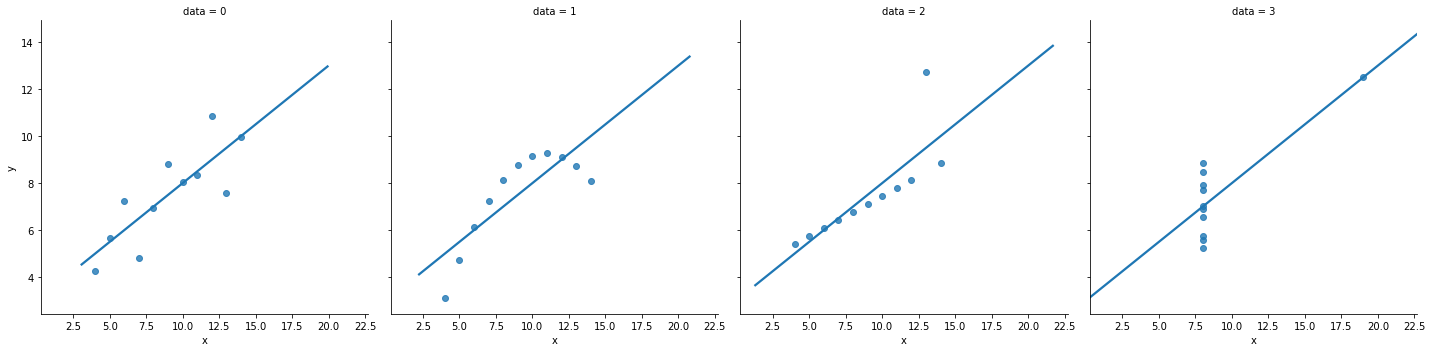

In [116]:
#grid = sns.FacetGrid(
#    anscombe,
#    col="data",
#    col_wrap=2,
#)
sns.lmplot(data=anscombe, col="data", x="x", y="y", ci=None)

In [ ]:
anscombe[anscombe["data"] == 1].describe()

In [ ]:
anscombe[anscombe["data"] == 0].describe()

In [ ]:
anscombe[anscombe["data"] == 0][["x", "y"]].corr()

In [ ]:
anscombe[anscombe["data"] == 1][["x", "y"]].corr()

Dovedeno do extrému, není vůbec problém nakreslit téměř libovolně vypadající obrázek alias bodový graf, který bude mít dané souhrnné statistiky. V pěkném interaktivním článku [Same Stats, Different Graphs...](https://www.autodeskresearch.com/publications/samestats) autoři ukazují pěkné animace plynulých přechodů mezi sadami, které se chovají podobně jako Anscombeho kvartet.

My si ukážeme aspoň statickou podobu:

In [14]:
# Data nejsou oddělená čárkami, ale tabulátory
datasaurus = pd.read_csv("static/datasaurus_dozen.tsv", delimiter="\t")
datasaurus.sample(10)

,dataset,x,y
1487,slant_up,54.855665,83.783398
1024,dots,52.589720,51.338090
1634,slant_down,53.385281,78.871136
277,away,52.033456,64.566662
1287,bullseye,27.560835,72.847826
927,high_lines,30.011264,68.146756
411,h_lines,57.053306,10.514069
1035,dots,27.892659,50.795282
353,h_lines,57.902687,89.618402
1061,dots,50.178672,83.184622


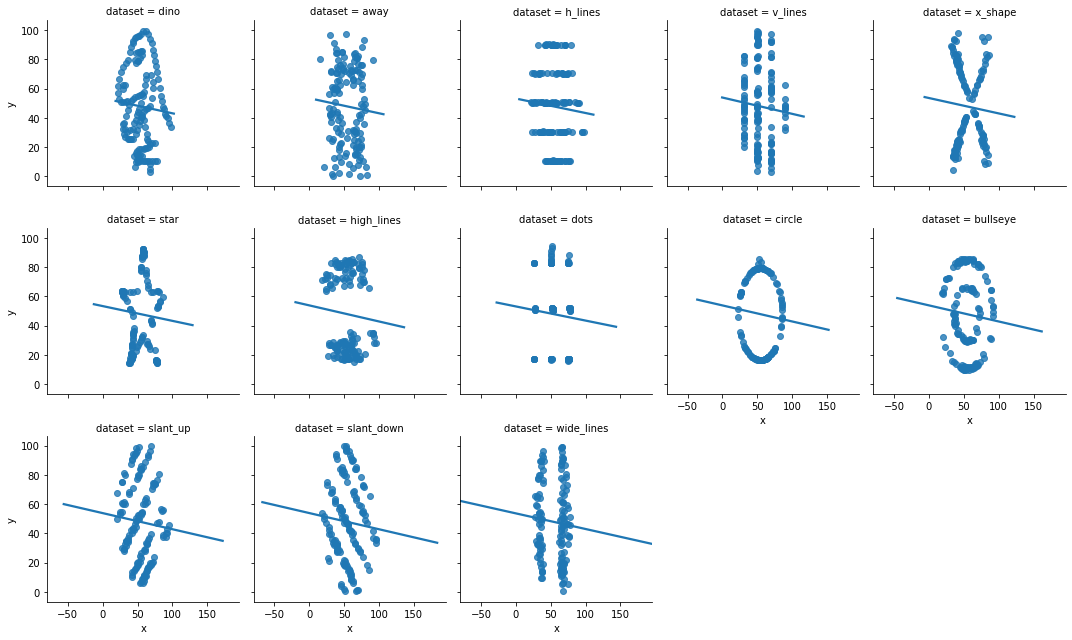

In [102]:
grid = sns.FacetGrid(
    datasaurus,
    col="dataset",
    col_wrap=5,
)
grid.map(sns.regplot, "x", "y", ci=None)

In [34]:
grouper = datasaurus.groupby("dataset")
single = grouper.agg({"x": ("mean", "std"), "y": ("mean", "std")})
correlation = grouper.apply(lambda g: g["x"].corr(g["y"])).rename("pearson_r")
single.join(correlation)

,"(x, mean)","(x, std)","(y, mean)","(y, std)",pearson_r
dataset,,,,,
away,54.266100,16.769825,47.834721,26.939743,-0.064128
bullseye,54.268730,16.769239,47.830823,26.935727,-0.068586
circle,54.267320,16.760013,47.837717,26.930036,-0.068343
dino,54.263273,16.765142,47.832253,26.935403,-0.064472
dots,54.260303,16.767735,47.839829,26.930192,-0.060341
h_lines,54.261442,16.765898,47.830252,26.939876,-0.061715
high_lines,54.268805,16.766704,47.835450,26.939998,-0.068504
slant_down,54.267849,16.766759,47.835896,26.936105,-0.068980
slant_up,54.265882,16.768853,47.831496,26.938608,-0.068609


Korelační koeficient: -0.0666079270385194


,x,y
count,100.000000,100.000000
mean,54.260000,47.830000
std,16.854484,27.075719
min,10.887127,-19.841522
25%,41.143948,29.283937
50%,55.479964,50.354194
75%,64.852547,67.048146
max,91.863508,112.626771


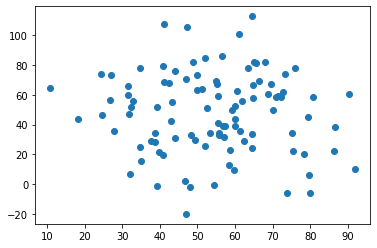

In [94]:
import numpy as np
x = np.random.normal(0, 1, 100)
y = np.random.normal(0, 1, 100)

while True:
    correlation = pd.Series(x).corr(pd.Series(y))
    if correlation < -0.067:
        y = y + (x * 0.001)
    elif correlation > -0.065:
        y = y - (x * 0.001)
    else:
        break
        
x = x * 16.77 / x.std()
x = x + 54.26 - x.mean()

y = y * 26.94 / y.std()
y = y + 47.83 - y.mean()

plt.scatter(x, y)
print("Korelační koeficient:", pd.Series(x).corr(pd.Series(y)))
pd.DataFrame({"x": x, "y": y}).describe()

### Heatmap

## Vztahy mezi více proměnnými

Pokud si tyto materiály nečteš na holografickém displeji, jsi při zobrazování dat omezen/a na dva rozměry. Můžeš si prohlížet dvourozměrné tabulky, kreslit dvourozměrné grafy.

In [ ]:
# scattermatrix

In [ ]:
# pairplot

In [ ]:
# catplot

In [ ]:
# 3D grafy

In [ ]:
import pandas as pd
kolac = pd.Series(
    [1, 1, 1] * 2,
    index = ["mák", "tvaroh", "povidla"] * 2
)
ax = kolac.plot.pie(
    figsize=(8, 8),
    title="Koláčový graf",
    colors=["#303090", "#ffffed", "#200040"] * 2,
    wedgeprops = {'linewidth': 15, 'edgecolor': "#ffa070"},
)
ax.set_ylabel(None);